In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))

Notebook is in: /home/sulab/tRNA-charge-seq/projects/masked-align_analysis
Repo is in: /home/sulab/tRNA-charge-seq


In [3]:
# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
from src.sankey import sankey
from src.comp_align import compare_SWalign

# Read sample list:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))

Repo is in: /home/sulab/tRNA-charge-seq


In [4]:
# Collect annotation comparison data:
snu_lst = list(set(sample_df['sample_name_unique']))
data_dir = '{}/data'.format(NBdir)
anno_df, codon_df = compare_SWalign(snu_lst, data_dir)

Now processing sample: 8h_p3  8h_p8  8h_p1  8h_p9  8h_p4  8h_p6  8h_p2  8h_p5  8h_p7 

In [5]:
dest_mask = (anno_df['count_a2_tot'] / anno_df['count_a1_tot']) > 100
dest_mask &= ~np.array(['@' in a for a in anno_df['anno2']])
anno2_mask = list(set(anno_df[dest_mask]['anno2'].values))
mask = anno_df['anno2'].isin(anno2_mask)
mask &= anno_df['count'] > 3000

a2cc_df = anno_df[mask].groupby('anno2').agg(anno2=('anno2', 'max'), \
                                             anno1_count=('anno1', 'count')).reset_index(drop=True)
sele_df = anno_df[mask].merge(a2cc_df, on='anno2')
mask = (sele_df['anno1_count'] > 1)

In [6]:
sum(mask)

25

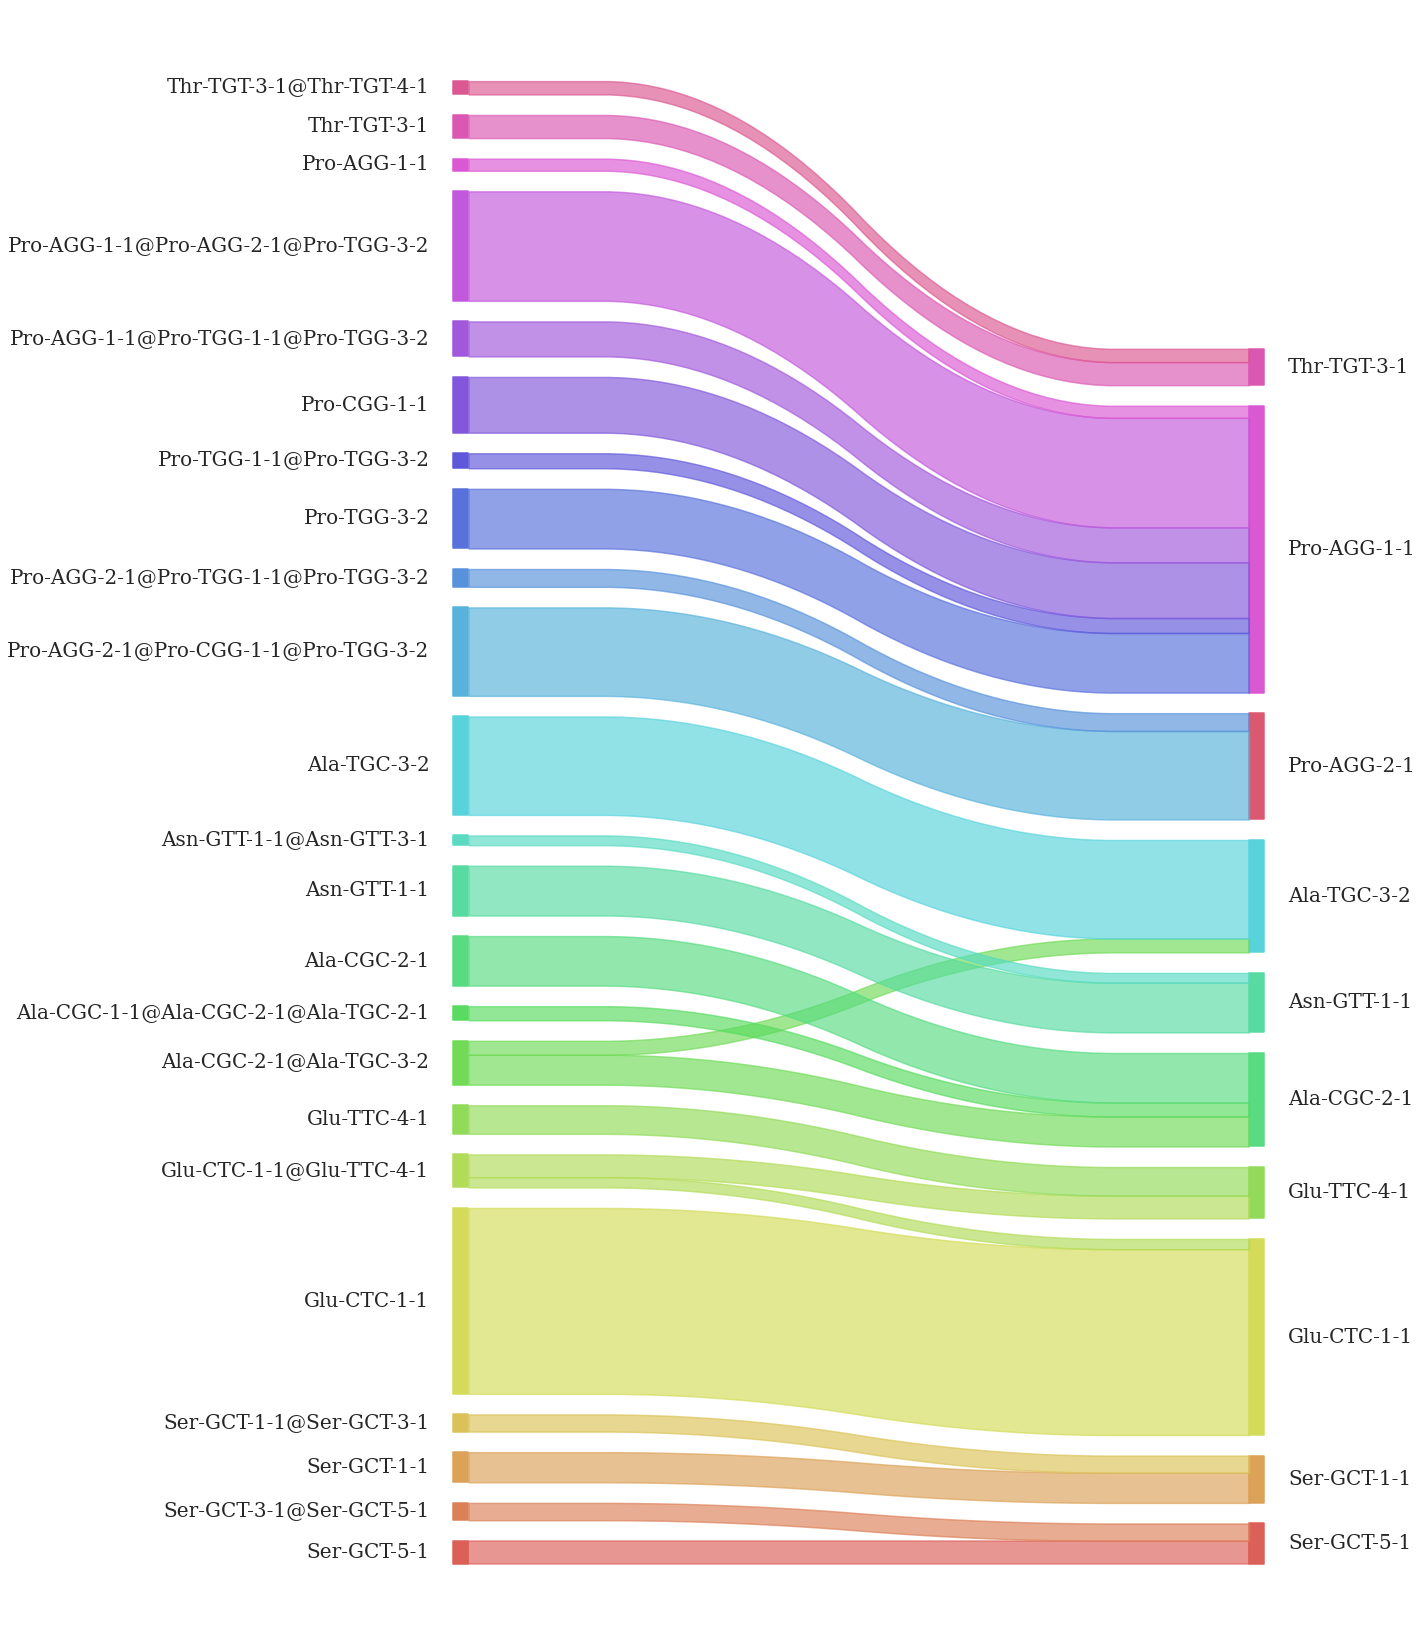

In [7]:
sankey(
    left=sele_df[mask]['anno1'], right=sele_df[mask]['anno2'], \
    leftWeight=sele_df[mask]['count'].values, rightWeight=sele_df[mask]['count'].values,\
    aspect=10, fontsize=20, figure_name="Annotation flow"
)

In [8]:
anno_df['count_a2_norm'] = anno_df['count'] / anno_df['count_a2_tot'] * 100
mask = anno_df['anno2'].isin(['Ser-AGA-2-1', 'Ser-AGA-1-1'\
                              'Pro-AGG-2-1', 'Val-AAC-1-1', 'Leu-AAG-1-1', 'Cys-GCA-11-1', \
                              'Ser-GCT-6-1', 'Asn-GTT-2-1', 'Lys-TTT-7-1', 'Ser-GCT-4-1', \
                              'Cys-GCA-6-1', 'Thr-TGT-4-1', 'Asn-GTT-24-1'])
mask &= anno_df['count_a2_norm'] > 5

In [9]:
sum(mask)

14

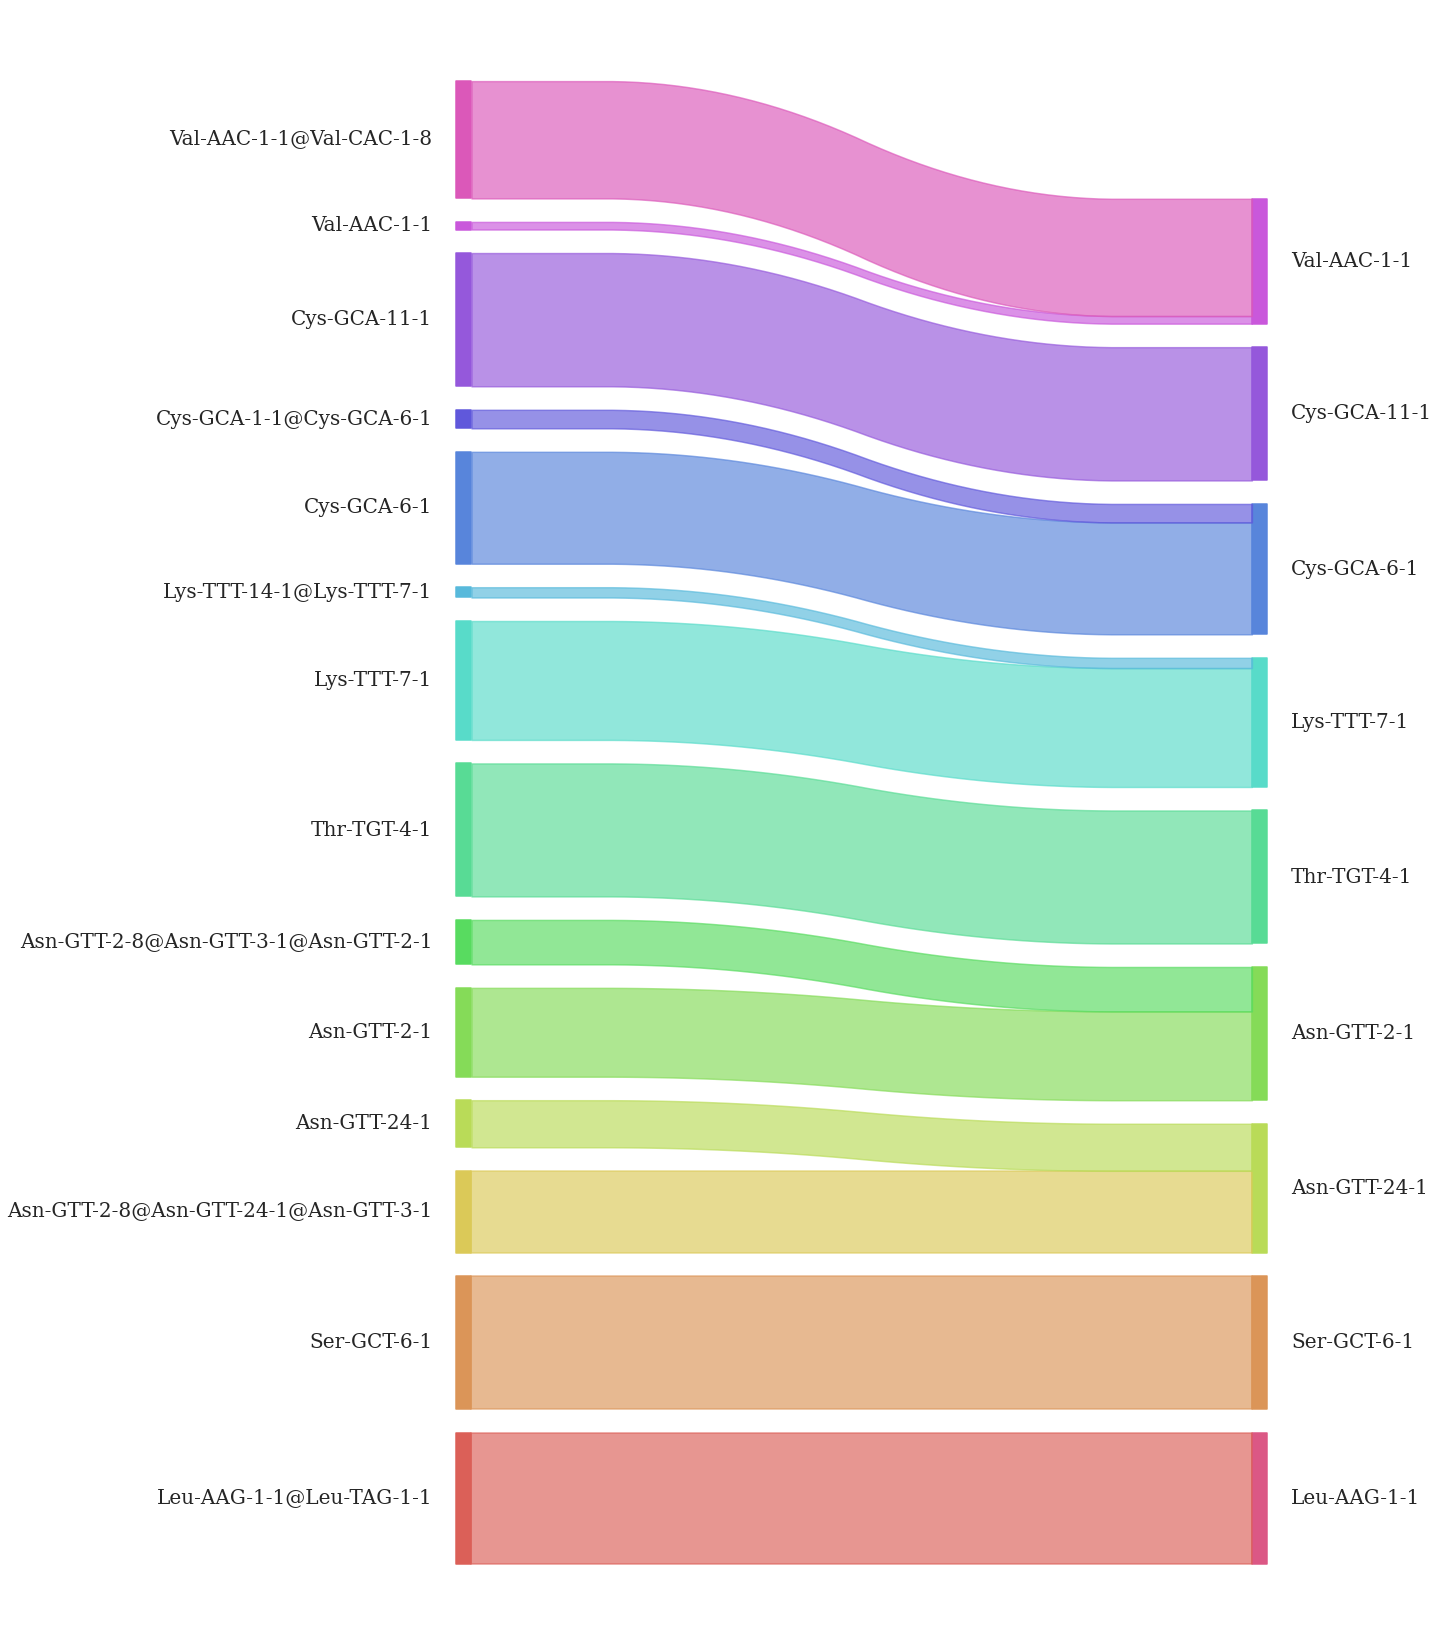

In [10]:
sankey(
    left=anno_df[mask]['anno1'], right=anno_df[mask]['anno2'], \
    leftWeight=anno_df[mask]['count_a2_norm'].values, rightWeight=anno_df[mask]['count_a2_norm'].values,\
    aspect=10, fontsize=20, figure_name="Annotation flow"
)

In [11]:
mask = (codon_df['codon1'] != codon_df['codon2']) & (codon_df['count'] > 30)
mask &= ~np.array(['@' in cd for cd in codon_df['codon1']])
mask &= ~np.array(['@' in cd for cd in codon_df['codon2']])

In [12]:
sum(mask)

18

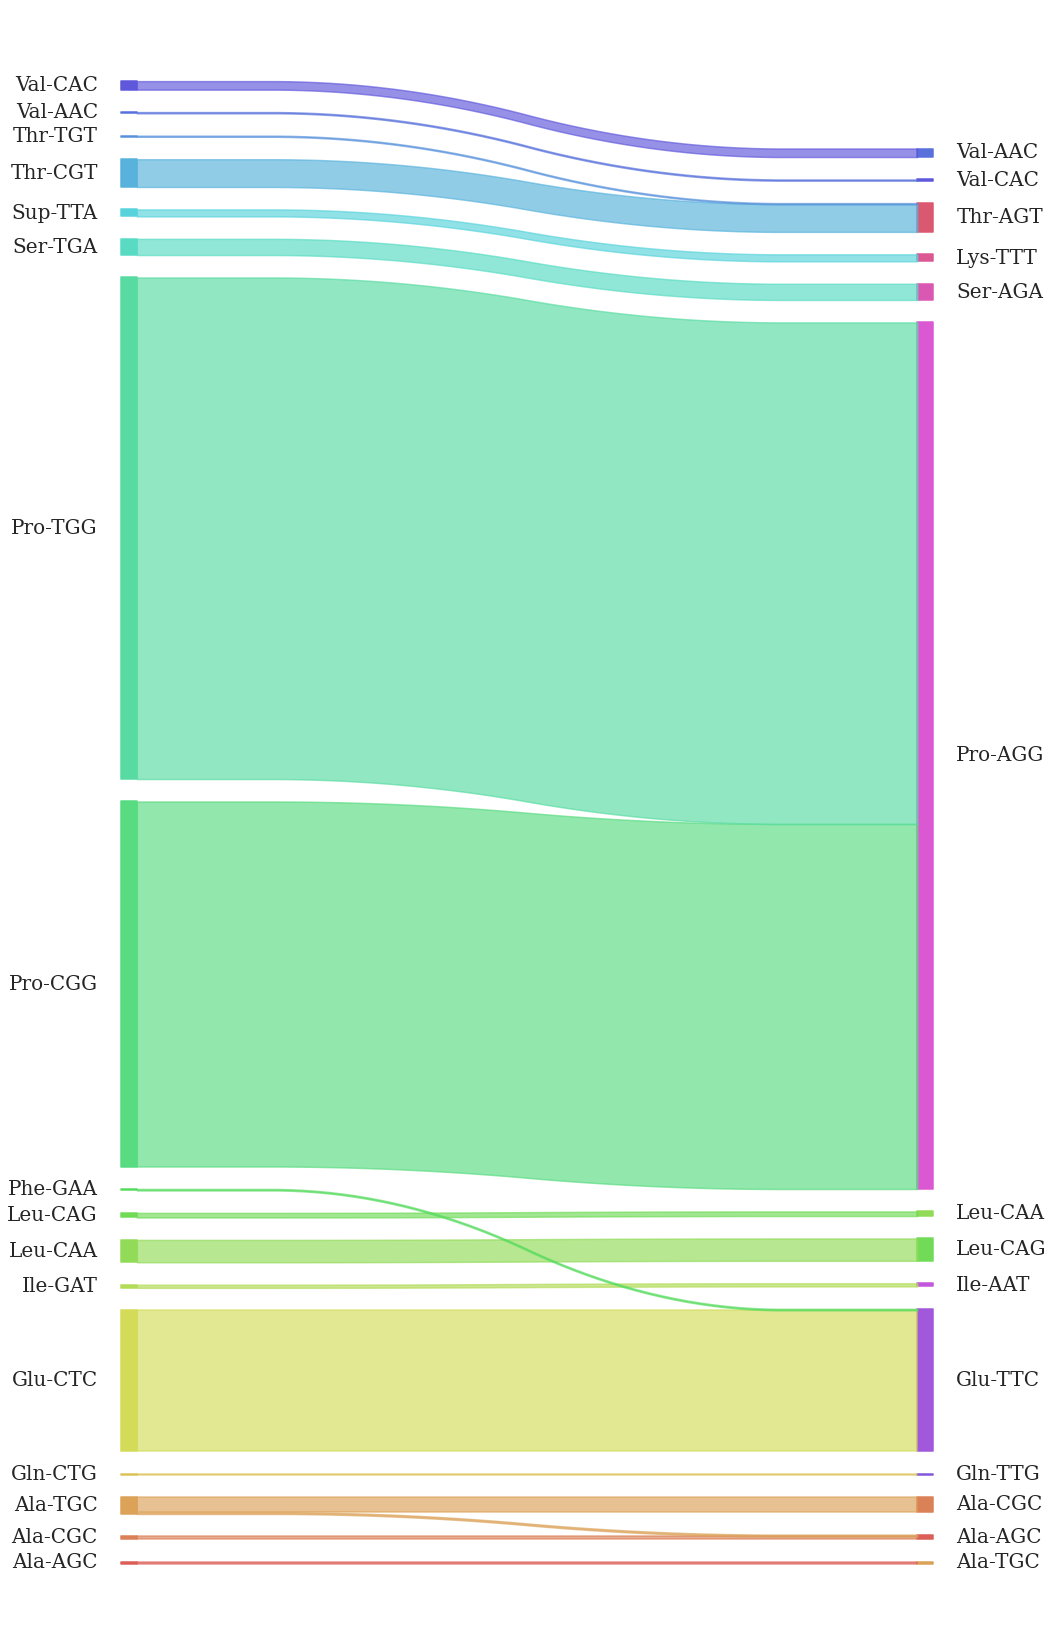

In [13]:
sankey(
    left=codon_df[mask]['codon1'], right=codon_df[mask]['codon2'], \
    leftWeight=codon_df[mask]['count'].values, rightWeight=codon_df[mask]['count'].values,\
    aspect=10, fontsize=20, figure_name="Annotation flow"
)

In [14]:
codon_df['count_a2_norm'] = codon_df['count'] / codon_df['count_c2_tot'] * 100
mask = (codon_df['codon2'].isin(['Ser-AGA', 'Pro-AGG', 'Val-AAC', 'Ala-CGC']))
mask &= (codon_df['count_a2_norm'] > 2)

In [15]:
sum(mask)

11

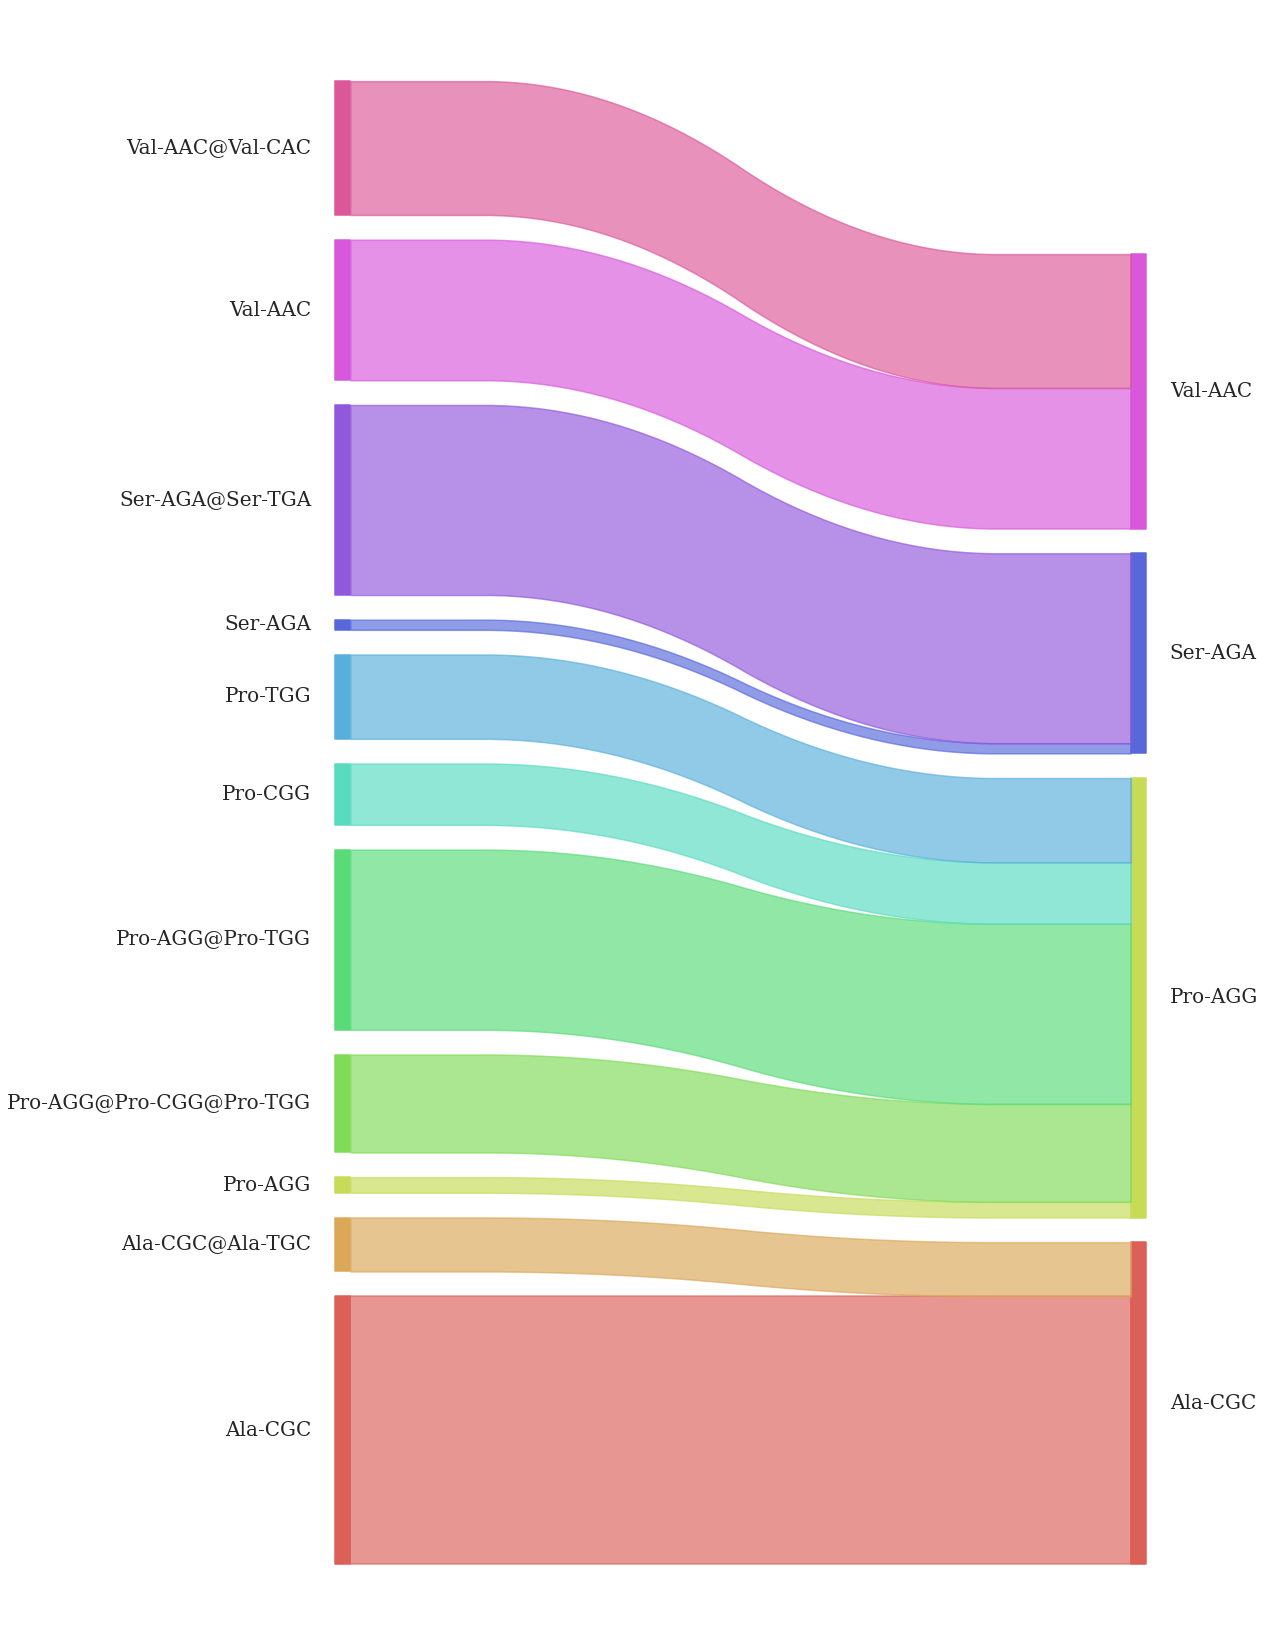

In [16]:
sankey(
    left=codon_df[mask]['codon1'], right=codon_df[mask]['codon2'], \
    leftWeight=codon_df[mask]['count'].values, rightWeight=codon_df[mask]['count'].values,\
    aspect=10, fontsize=20, figure_name="Annotation flow"
)